In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from ast import literal_eval

Folder names:
* data - run - 100: 100 runs on bots count 0, 25, 50
* data and images: 50 runs on bots count 0, 10, 20, 30, 50
* data-bot-personality: 50 runs bot count 0, 25, 50 - personality factor changed
* fake: only fake threshold changed - 50 runs
* fake effect: changed fake_threshold and fake_emotion_change
* moderation: adjusting values for unpopular_scale and unrelated_scale

In [342]:
def convert_array_cols(data):
    """data: 1 observation in 1 column"""
    s = data.split('\r\n ')
    for i in range(len(s)):
        if i == 0:
            s[i] = s[i][1:]
        else:
            s[i] = s[i][:-1] 
        s[i] = s[i].replace('[','').replace(']','').replace('.','')
        s[i] = np.fromstring(s[i], dtype = float, sep = ' ')
    return np.array(s)

def convert_dict_cols(data, mult_values = False):
    """
    data: 1 observation in 1 column
    mult_values: False if dictionary value is not a tuple
    """
    d = literal_eval(data.replace("nan","'np.nan'"))
    if mult_values:
        return {k: tuple(t if t != 'np.nan' else np.nan for t in v) for k, v in d.items()}
    else:
        return {k: (v if v != 'np.nan' else np.nan) for k, v in d.items()}

def convert_df_dtypes(df):
    df['agent_counts'] = df['agent_counts'].apply(lambda data: convert_array_cols(data))
    df['avg_falseness'] = df['avg_falseness'].apply(lambda data: convert_dict_cols(data))
    df['median_falseness'] = df['median_falseness'].apply(lambda data: convert_dict_cols(data))
    df['dist_falseness'] = df['dist_falseness'].apply(lambda data: convert_dict_cols(data))
    df['beliefs'] = df['beliefs'].apply(lambda data: convert_dict_cols(data, True))
    df['bot_percentage'] = df['bot_percentage'].apply(lambda data: convert_array_cols(data))
    df['Agent_emotion_dist'] = df['Agent_emotion_dist'].apply(lambda data: convert_array_cols(data))
    df['Agent_belief_dist'] = df['Agent_belief_dist'].apply(lambda data: convert_array_cols(data))
    df['Post_emotion_dist'] = df['Post_emotion_dist'].apply(lambda data: convert_array_cols(data))
    df['Post_belief_dist'] = df['Post_belief_dist'].apply(lambda data: convert_array_cols(data))
    return df

# process falseness and belief dfs for plotting
def get_falseness_df(df, col_name):
    false_df = pd.DataFrame(columns = df[col_name][0].keys())
    for col in false_df.columns:
        false_df[col] = [v for step in df[col_name] for k, v in step.items() if k == col]
    return false_df

def get_belief_df(df, belief_type):
    """belief_type: 'view', 'like', or 'post'"""
    belief_df = pd.DataFrame(columns = df['beliefs'][0].keys())
    if belief_type == 'view':
        idx = 0
    elif belief_type == 'like':
        idx = 1
    elif belief_type == 'post':
        idx = 2
    for col in belief_df.columns:
        belief_df[col] = [v[idx] for step in df['beliefs'] for k, v in step.items() if k == col]
    return belief_df

# aggregate falseness metrics across simulation runs
def agg_avg_falseness(df_list):
    avg_falseness_list = [get_falseness_df(df, 'avg_falseness') for df in df_list]
#     print(avg_falseness_list)
    
    avg_false_agg = pd.DataFrame(columns = avg_falseness_list[0].columns)
    for col in avg_false_agg.columns:
        avg_false_agg[col] = np.mean([df_avg[col] for df_avg in avg_falseness_list], axis=0)
        
    
    return avg_false_agg

def agg_med_falseness(df_list):
    med_falseness_list = [get_falseness_df(df, 'median_falseness') for df in df_list]
    
    med_false_agg = pd.DataFrame(columns = med_falseness_list[0].columns)
    for col in med_false_agg.columns:
        med_false_agg[col] = np.mean([df[col] for df in med_falseness_list], axis=0)
    
    return med_false_agg

In [264]:
dir_names = [f for f in os.listdir() if '.' not in f and f not in ['data','falseness','images']]
    
# all dataframes
raw_sim_data = {}
for simulation in dir_names:
    files = os.listdir(simulation)
    raw_sim_data[simulation] = {
        f.replace('.csv',''):
            convert_df_dtypes(pd.read_csv(os.path.join(simulation, f))) for f in files
    }
    
sorted_sim_data = {d: {} for d in dir_names}

for sim in raw_sim_data.keys():
    for run in raw_sim_data[sim].keys():
        run_type = run.split('iteration -')
        iteration = int(run_type[1][0])
        run_type = run_type[1][2:]
        if iteration == 0:
            sorted_sim_data[sim][run_type] = []
        sorted_sim_data[sim][run_type].append(raw_sim_data[sim][run])
        
agg_sim_data = {}

for sim in sorted_sim_data.keys():
    agg_sim_data[sim] = {}
    for run in sorted_sim_data[sim].keys():
        df_list = sorted_sim_data[sim][run]
        agg_df = pd.DataFrame(columns = df_list[0].columns)
        agg_df['emotion'] = np.mean([df['emotion'] for df in df_list], axis=0)
        avg_falseness = dict(agg_avg_falseness(df_list).T)
        med_falseness = dict(agg_med_falseness(df_list).T)
        for i in range(len(avg_falseness)):
            agg_df['avg_falseness'].iloc[i] = dict(avg_falseness[i])
            agg_df['median_falseness'].iloc[i] = dict(med_falseness[i])
        agg_sim_data[sim][run] = agg_df

c:\users\rc\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


In [475]:
for sim in agg_sim_data.keys():
    print(sim)
    for run in agg_sim_data[sim].keys():
        print(run)

data - run - 100
bot count -0
bot count -25
bot count -50
data and images - run 1
bot count -0
bot count -10
bot count -20
bot count -30
bot count -50
data-bot-personality-50
bot count -0 personality factor -1
bot count -0 personality factor -10
bot count -0 personality factor -100
bot count -25 personality factor -1
bot count -25 personality factor -10
bot count -25 personality factor -100
bot count -50 personality factor -1
bot count -50 personality factor -10
bot count -50 personality factor -100
fake
threshold -1.2
threshold -1.5
threshold -1.8
fake effect and threshold
threshold -1.2 effect --0.0005
threshold -1.2 effect --1e-05
threshold -1.2 effect -0.0005
threshold -1.8 effect --0.0005
threshold -1.8 effect --1e-05
threshold -1.8 effect -0.0005
threshold -1.2
threshold -1.5
threshold -1.8
moderation 3-7
bot count -0
bot count -25
bot count -50


In [ ]:
# global plotting variables
labels = ['1: Against,\nLow Unpop,\nSome Unrel','2: Against,\nLow Unpop,\nMost Unrel',
          '3: Against,\nMed Unpop,\nSome Unrel','4: Against,\nMed Unpop,\nMost Unrel',
          '5: Against,\nHigh Unpop,\nSome Unrel','6: Against,\nHigh Unpop,\nMost Unrel',
          '7: Pro,\nLow Unpop,\nSome Unrel','8: Pro,\nLow Unpop,\nMost Unrel',
          '9: Pro,\nMed Unpop,\nSome Unrel','10: Pro,\nMed Unpop,\nMost Unrel',
          '11: Pro,\nHigh Unpop,\nSome Unrel','12: Pro,\nHigh Unpop,\nMost Unrel']
colors=['darkred','brown','red','tomato','salmon','lightsalmon','lightblue','lightskyblue',
        'dodgerblue','blue','darkblue','black']

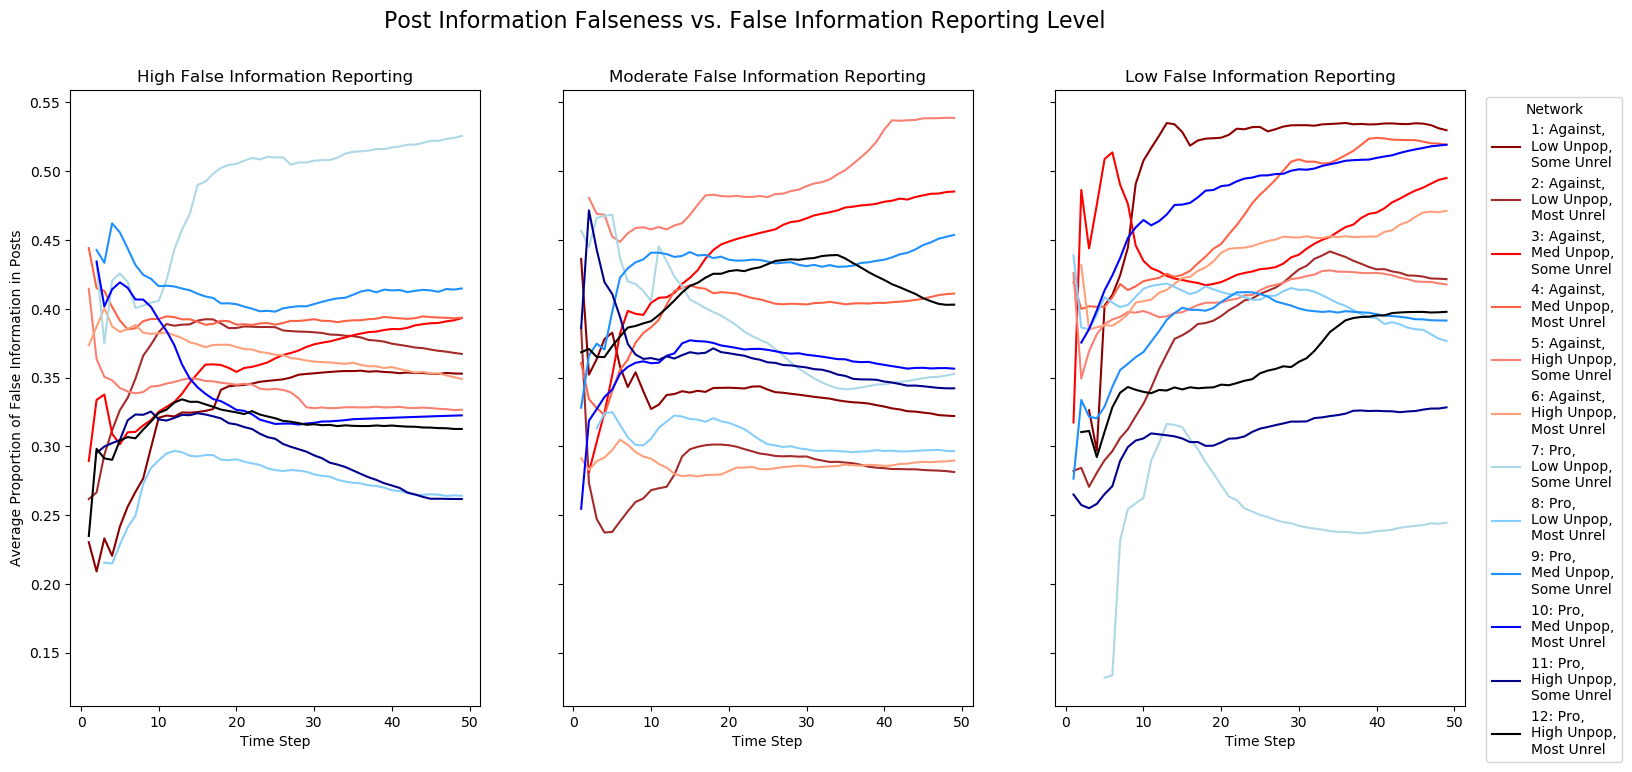

In [608]:
new_df0 = pd.DataFrame()
for i in range(len(agg_sim_data['fake']['threshold -1.2']['avg_falseness'])):
    new_df0 = new_df0.append(
        pd.DataFrame(agg_sim_data['fake']['threshold -1.2']['avg_falseness'][i]).T,
        ignore_index=True)
    
new_df25 = pd.DataFrame()
for i in range(len(agg_sim_data['fake']['threshold -1.5']['avg_falseness'])):
    new_df25 = new_df25.append(
        pd.DataFrame(agg_sim_data['fake']['threshold -1.5']['avg_falseness'][i]).T,
        ignore_index=True)
    
new_df50 = pd.DataFrame()
for i in range(len(agg_sim_data['fake']['threshold -1.8']['avg_falseness'])):
    new_df50 = new_df50.append(
        pd.DataFrame(agg_sim_data['fake']['threshold -1.8']['avg_falseness'][i]).T,
        ignore_index=True)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 8))
for i in range(len(new_df0.columns)):
    sns.lineplot(x=new_df0.index, y = new_df0.columns[i], data=new_df0, color=colors[i], ax=ax[0])
for i in range(len(new_df25.columns)):
    sns.lineplot(x=new_df25.index, y = new_df25.columns[i], data=new_df25, color=colors[i], ax=ax[1])
for i in range(len(new_df50.columns)):
    sns.lineplot(x=new_df50.index, y = new_df50.columns[i], data=new_df50, color=colors[i], ax=ax[2])
ax[0].set_title('High False Information Reporting')
ax[1].set_title('Moderate False Information Reporting')
ax[2].set_title('Low False Information Reporting')
ax[0].set_ylabel('Average Proportion of False Information in Posts')
ax[0].set_xlabel('Time Step')
ax[1].set_xlabel('Time Step')
ax[2].set_xlabel('Time Step')
ax[2].legend(labels, title='Network', loc='upper right', bbox_to_anchor=(1.4, 1))
fig.suptitle('Post Information Falseness vs. False Information Reporting Level', size=16)
fig.savefig('hypo1_reporting.png')
plt.show()

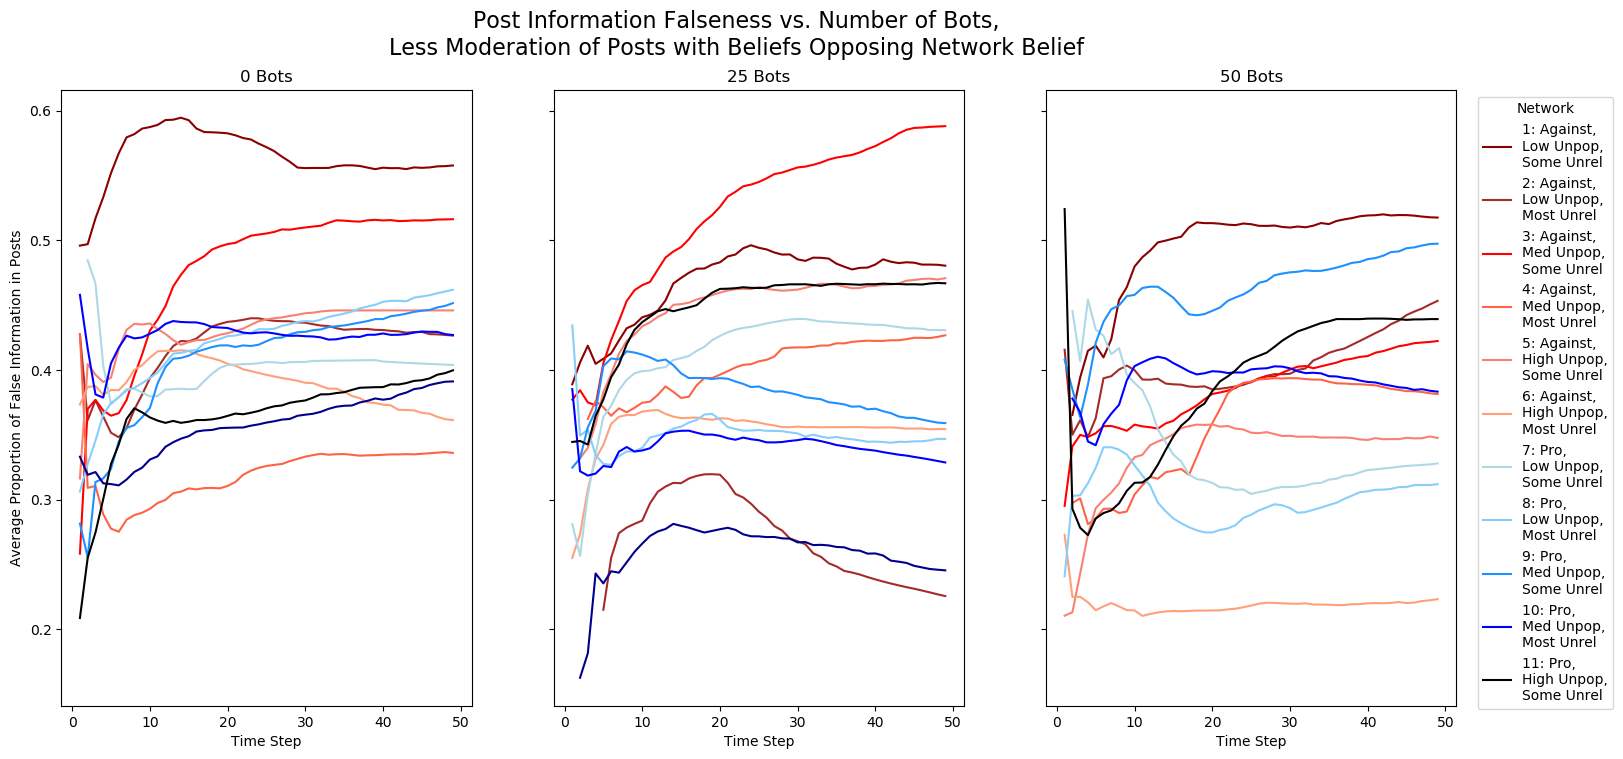

In [605]:
new_df0 = pd.DataFrame()
for i in range(len(agg_sim_data['moderation 3-7']['bot count -0']['avg_falseness'])):
    new_df0 = new_df0.append(
        pd.DataFrame(agg_sim_data['moderation 3-7']['bot count -0']['avg_falseness'][i]).T,
        ignore_index=True)
    
new_df25 = pd.DataFrame()
for i in range(len(agg_sim_data['moderation 3-7']['bot count -25']['avg_falseness'])):
    new_df25 = new_df25.append(
        pd.DataFrame(agg_sim_data['moderation 3-7']['bot count -25']['avg_falseness'][i]).T,
        ignore_index=True)
    
new_df50 = pd.DataFrame()
for i in range(len(agg_sim_data['moderation 3-7']['bot count -50']['avg_falseness'])):
    new_df50 = new_df50.append(
        pd.DataFrame(agg_sim_data['moderation 3-7']['bot count -50']['avg_falseness'][i]).T,
        ignore_index=True)

fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 8))
for i in range(len(new_df0.columns)):
    sns.lineplot(x=new_df0.index, y = new_df0.columns[i], data=new_df0, color=colors[i], ax=ax[0])
for i in range(len(new_df25.columns)):
    sns.lineplot(x=new_df25.index, y = new_df25.columns[i], data=new_df25, color=colors[i], ax=ax[1])
for i in range(len(new_df50.columns)):
    sns.lineplot(x=new_df50.index, y = new_df50.columns[i], data=new_df50, color=colors[i], ax=ax[2])
ax[0].set_title('0 Bots')
ax[1].set_title('25 Bots')
ax[2].set_title('50 Bots')
ax[0].set_ylabel('Average Proportion of False Information in Posts')
ax[0].set_xlabel('Time Step')
ax[1].set_xlabel('Time Step')
ax[2].set_xlabel('Time Step')
ax[2].legend(labels, title='Network', loc='upper right', bbox_to_anchor=(1.4, 1))
fig.suptitle('Post Information Falseness vs. Number of Bots,\nLess Moderation of Posts with Beliefs Opposing Network Belief', size=16)
fig.savefig('hypo1_bots_opposing.png')
plt.show()

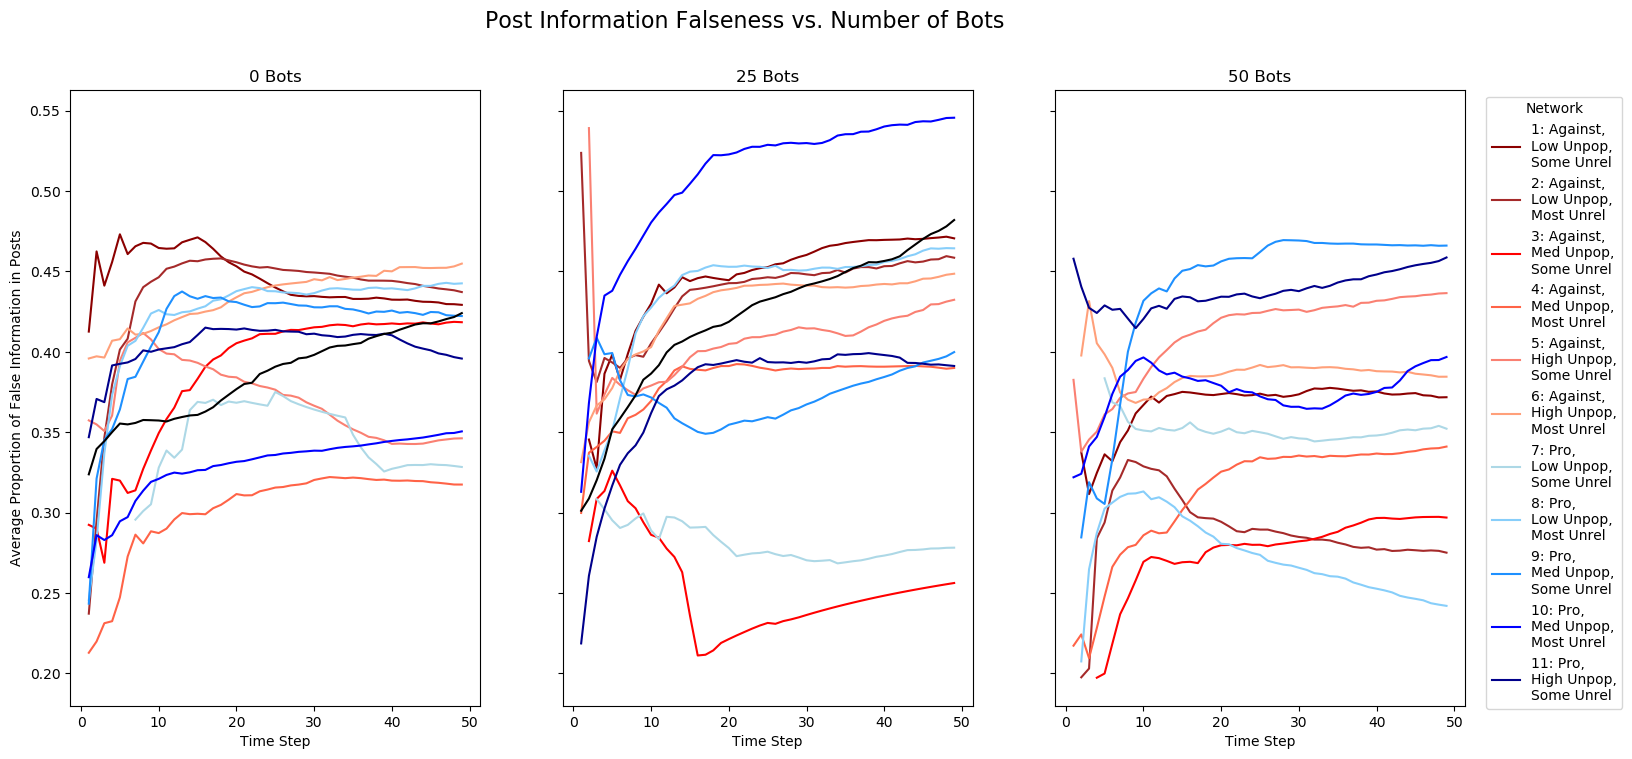

In [606]:
new_df0 = pd.DataFrame()
for i in range(50):
    new_df0 = new_df0.append(
        pd.DataFrame(agg_sim_data['data - run - 100']['bot count -0']['avg_falseness'][i]).T,
        ignore_index=True)
    
new_df25 = pd.DataFrame()
for i in range(50):
    new_df25 = new_df25.append(
        pd.DataFrame(agg_sim_data['data - run - 100']['bot count -25']['avg_falseness'][i]).T,
        ignore_index=True)
    
new_df50 = pd.DataFrame()
for i in range(50):
    new_df50 = new_df50.append(
        pd.DataFrame(agg_sim_data['data - run - 100']['bot count -50']['avg_falseness'][i]).T,
        ignore_index=True)


fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18, 8))
for i in range(len(new_df0.columns)):
    sns.lineplot(x=new_df0.index, y = new_df0.columns[i], data=new_df0, color=colors[i], ax=ax[0])
for i in range(len(new_df25.columns)):
    sns.lineplot(x=new_df25.index, y = new_df25.columns[i], data=new_df25, color=colors[i], ax=ax[1])
for i in range(len(new_df50.columns)):
    sns.lineplot(x=new_df50.index, y = new_df50.columns[i], data=new_df50, color=colors[i], ax=ax[2])
ax[0].set_title('0 Bots')
ax[1].set_title('25 Bots')
ax[2].set_title('50 Bots')
ax[0].set_ylabel('Average Proportion of False Information in Posts')
ax[0].set_xlabel('Time Step')
ax[1].set_xlabel('Time Step')
ax[2].set_xlabel('Time Step')
ax[2].legend(labels, title='Network', loc='upper right', bbox_to_anchor=(1.4, 1))
fig.suptitle('Post Information Falseness vs. Number of Bots', size=16)
fig.savefig('hypo1_bots.png')
plt.show()

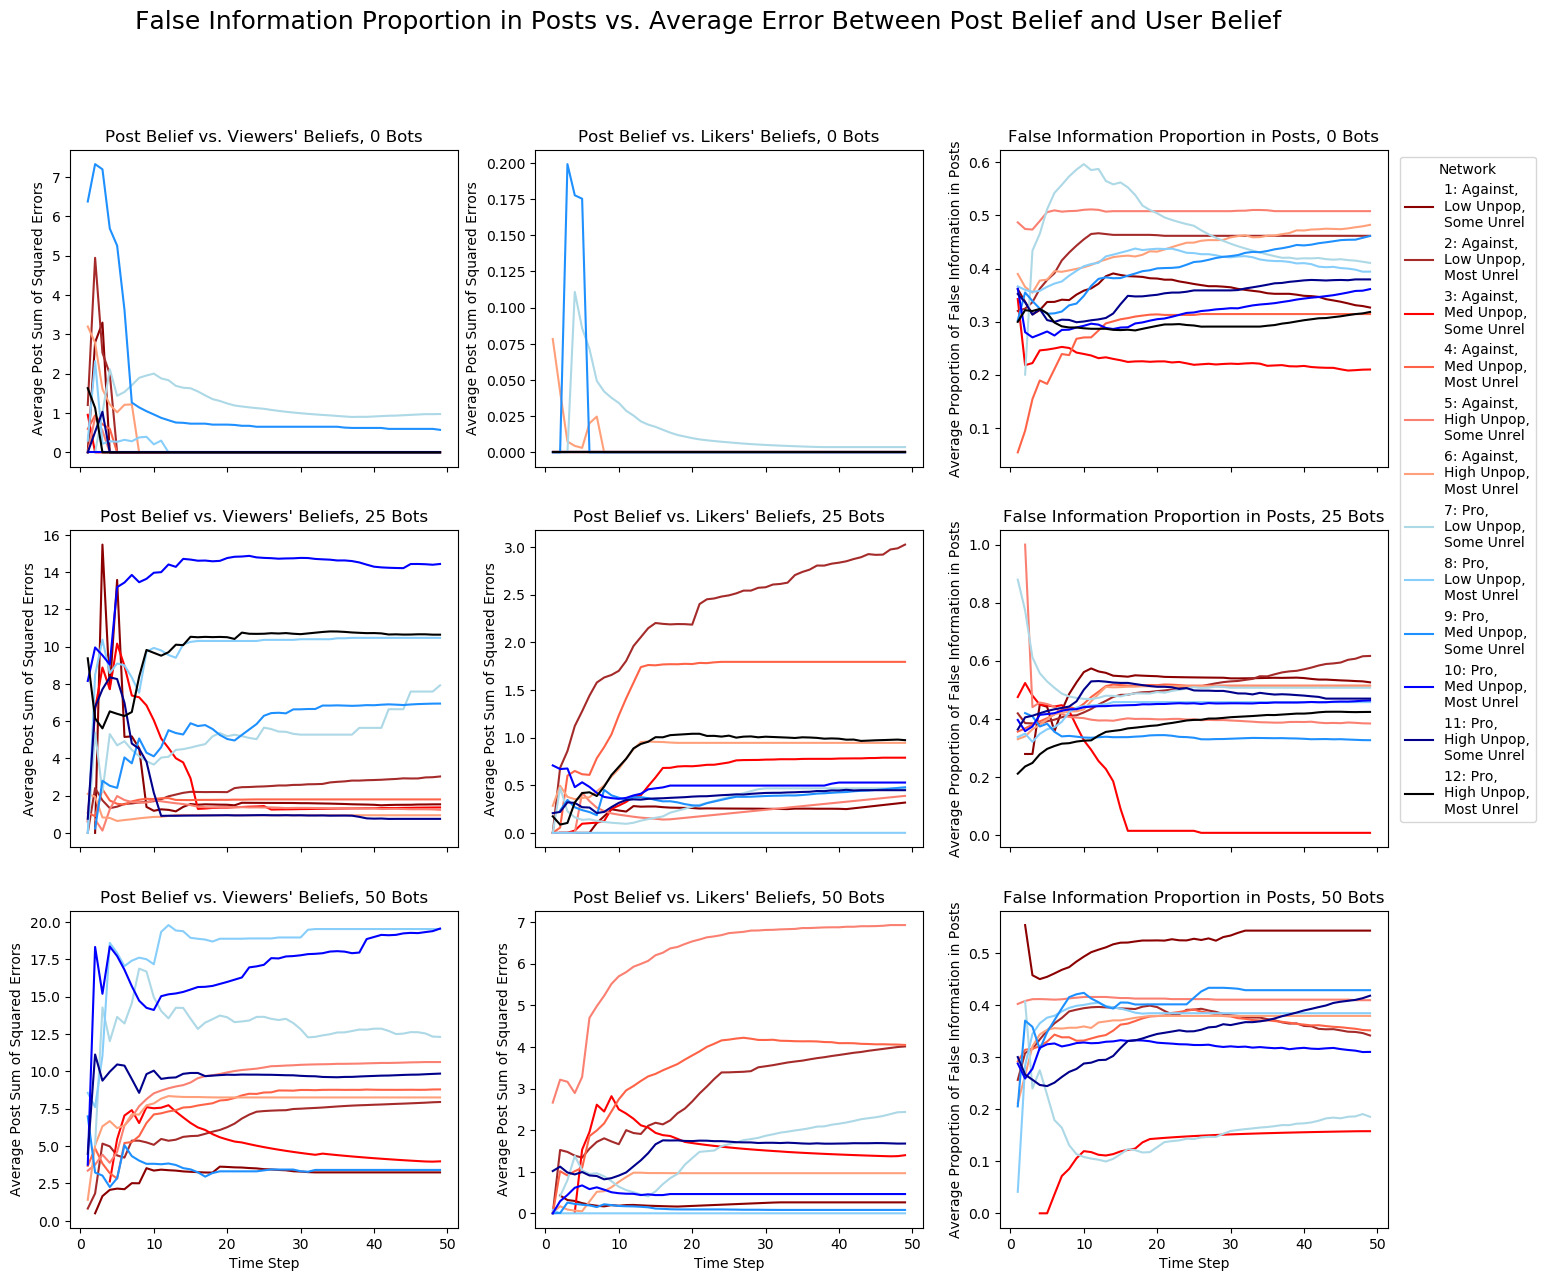

In [658]:
fig, ax = plt.subplots(3, 3, sharex=True, figsize=(17, 14))
bot_counts = [0, 25, 50]

for j in range(3):
    df = raw_sim_data['data - run - 100'][f'bot test iteration -1 bot count -{bot_counts[j]}']

    view_belief_df = get_belief_df(df, 'view')[:50]
    like_belief_df = get_belief_df(df, 'like')[:50]
    false_df = get_falseness_df(df, 'avg_falseness')[:50]
    
    for i in range(len(view_belief_df.columns)):
        sns.lineplot(x=view_belief_df.index, y = view_belief_df.columns[i], data=view_belief_df, color=colors[i],
                     ax=ax[j, 0])
    for i in range(len(like_belief_df.columns)):
        sns.lineplot(x=like_belief_df.index, y = like_belief_df.columns[i], data=like_belief_df, color=colors[i],
                     ax=ax[j, 1])
    for i in range(len(false_df.columns)):
        sns.lineplot(x=false_df.index, y = false_df.columns[i], data=false_df, color=colors[i], ax=ax[j, 2])
    ax[j, 0].set_title(f"Post Belief vs. Viewers' Beliefs, {bot_counts[j]} Bots")
    ax[j, 1].set_title(f"Post Belief vs. Likers' Beliefs, {bot_counts[j]} Bots")
    ax[j, 2].set_title(f"False Information Proportion in Posts, {bot_counts[j]} Bots")
    ax[j, 0].set_ylabel('Average Post Sum of Squared Errors')
    ax[j, 1].set_ylabel('Average Post Sum of Squared Errors')
    ax[j, 2].set_ylabel('Average Proportion of False Information in Posts')
    if j == 2:
        ax[j, 0].set_xlabel('Time Step')
        ax[j, 1].set_xlabel('Time Step')
        ax[j, 2].set_xlabel('Time Step')

ax[0, 2].legend(labels, title='Network', loc='upper right', bbox_to_anchor=(1.4, 1))
fig.suptitle('False Information Proportion in Posts vs. Average Error Between Post Belief and User Belief', size=18)
fig.savefig('hypo1_error1.png')

plt.show()

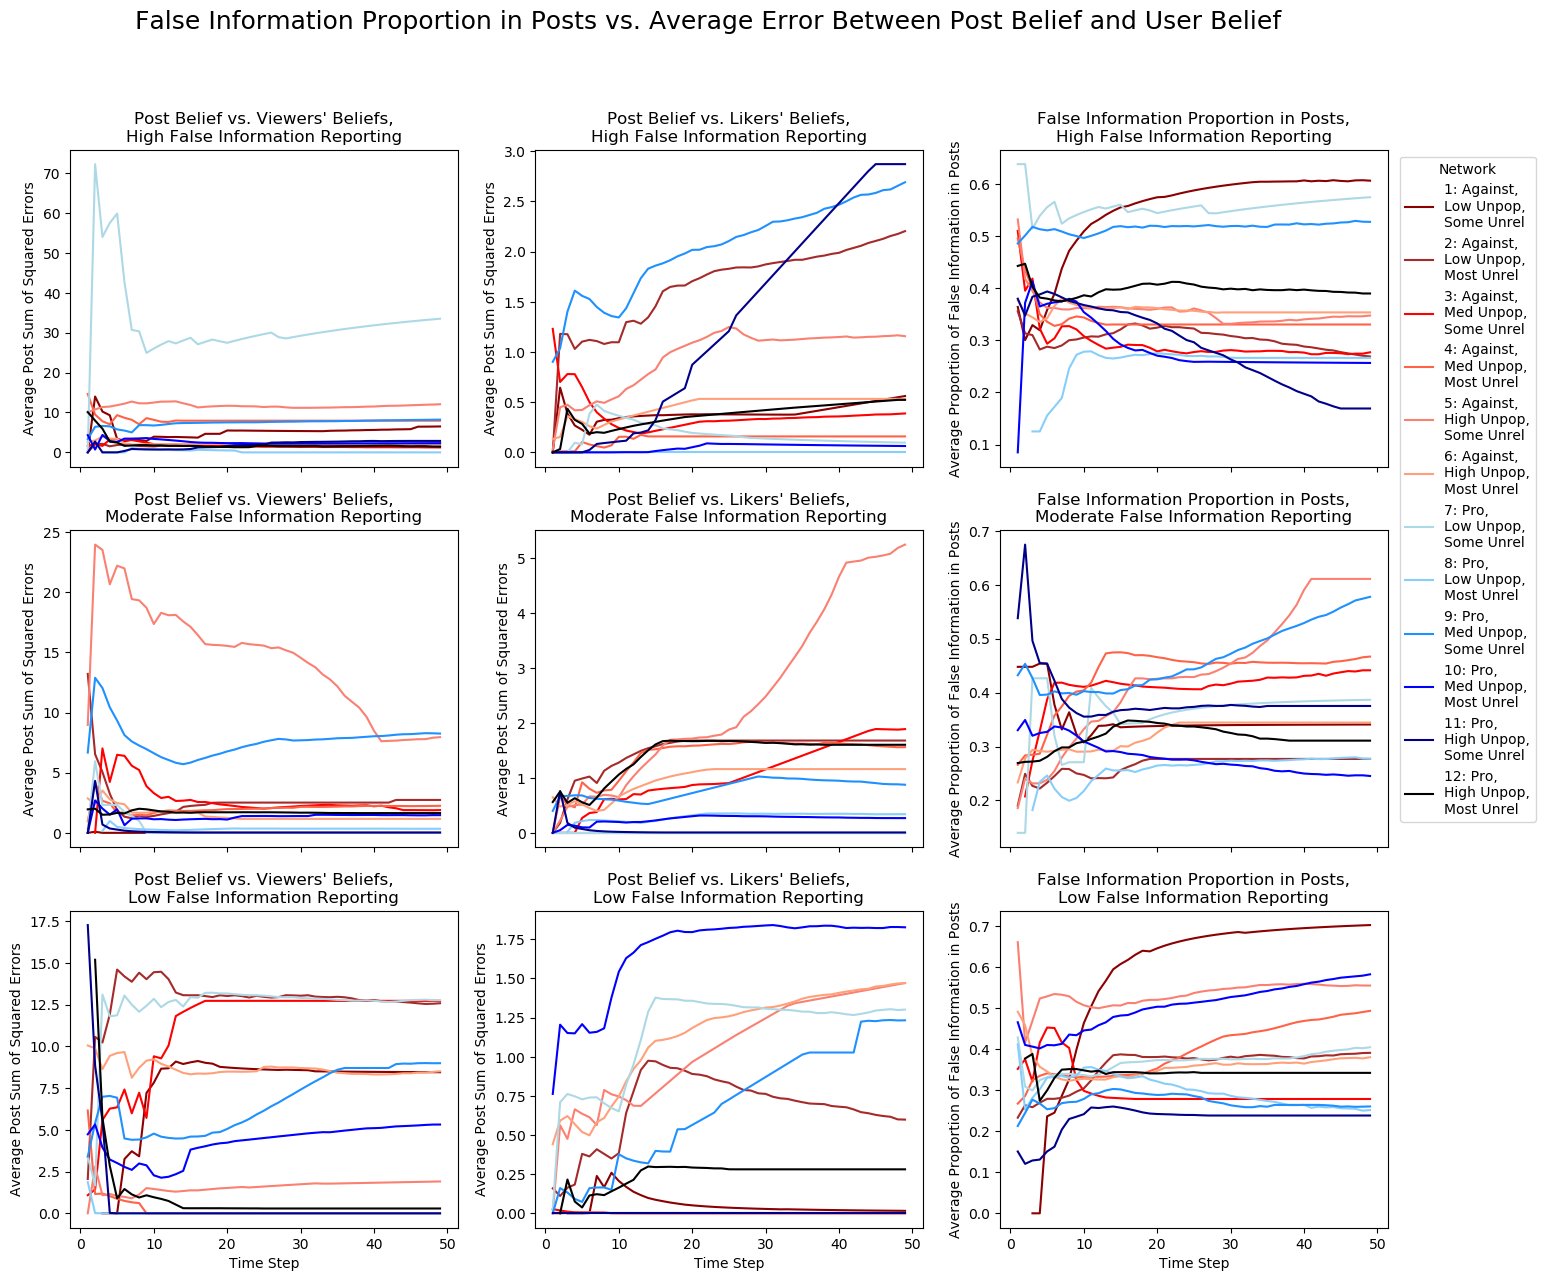

In [660]:
fig, ax = plt.subplots(3, 3, sharex=True, figsize=(17, 14))
threshold = [1.2, 1.5, 1.8]
threshold_label = ['High','Moderate','Low']

for j in range(3):
    df = raw_sim_data['fake'][f'fake threshold iteration -2 threshold -{threshold[j]}']
    
    view_belief_df = get_belief_df(df, 'view')[:50]
    like_belief_df = get_belief_df(df, 'like')[:50]
    false_df = get_falseness_df(df, 'avg_falseness')[:50]
    
    for i in range(len(view_belief_df.columns)):
        sns.lineplot(x=view_belief_df.index, y = view_belief_df.columns[i], data=view_belief_df, color=colors[i],
                     ax=ax[j, 0])
    for i in range(len(like_belief_df.columns)):
        sns.lineplot(x=like_belief_df.index, y = like_belief_df.columns[i], data=like_belief_df, color=colors[i],
                     ax=ax[j, 1])
    for i in range(len(false_df.columns)):
        sns.lineplot(x=false_df.index, y = false_df.columns[i], data=false_df, color=colors[i], ax=ax[j, 2])
    ax[j, 0].set_title(f"Post Belief vs. Viewers' Beliefs,\n{threshold_label[j]} False Information Reporting")
    ax[j, 1].set_title(f"Post Belief vs. Likers' Beliefs,\n{threshold_label[j]} False Information Reporting")
    ax[j, 2].set_title(f"False Information Proportion in Posts,\n{threshold_label[j]} False Information Reporting")
    ax[j, 0].set_ylabel('Average Post Sum of Squared Errors')
    ax[j, 1].set_ylabel('Average Post Sum of Squared Errors')
    ax[j, 2].set_ylabel('Average Proportion of False Information in Posts')
    if j == 2:
        ax[j, 0].set_xlabel('Time Step')
        ax[j, 1].set_xlabel('Time Step')
        ax[j, 2].set_xlabel('Time Step')

ax[0, 2].legend(labels, title='Network', loc='upper right', bbox_to_anchor=(1.4, 1))
fig.suptitle('False Information Proportion in Posts vs. Average Error Between Post Belief and User Belief', size=18)
fig.savefig('hypo1_error2.png')
        
plt.show()